In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import re
import os
from pathlib import Path
import shutil
import sys
import argparse
import csv
import random
import time
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split as tts

from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt

import cudf

/usr4/spclpgm/zhoua25/.local/lib/python3.10/site-packages/cupy/_environment.py:487: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
kelvin_offset = 273.15

def getDimensions(file, layer):
    columns = cudf.read_csv(file, nrows=1)
    nrows = 0
    ncols = 0
    while f'V(NODE{layer}_{nrows}_0)' in columns:
        nrows += 1
    while f'V(NODE{layer}_0_{ncols})' in columns:
        ncols += 1
    return nrows, ncols


def readFormatInput(file, n_rows, n_cols, layer):
    column = [f'V(NODE{layer}_{row}_{col})' for row in range(n_rows) for col in range(n_cols)]
    df_l = cudf.read_csv(file, usecols=column)
    return df_l

def getTemp(file, layer):
    grid_rows, grid_cols = getDimensions(file, layer)
    df_l = readFormatInput(file, grid_rows, grid_cols, layer)
    df_l -= kelvin_offset
    return df_l

In [3]:
os.chdir('different_ptraces')
folders = os.listdir()


ptrace_files_path = []

for folder in folders:
    os.chdir(f'{folder}')
    files = os.listdir()
    for file in files:
        if "scaled" in file:
            path = os.getcwd()
            ptrace_files_path.append(f"{path}/{file}")
            os.chdir('../')
os.chdir('../')

os.chdir('outputs')
outputs = os.listdir()
temp_files_paths = []

for file in outputs:
    path = os.getcwd()
    temp_files_paths.append(f"{path}/{file}")
os.chdir('../')

In [4]:
#layer 4 powers
powers = []
cores = cudf.DataFrame()
i = 0
for file in ptrace_files_path:
    d = cudf.read_csv(file, header = 0)
    powers.append(d['Power'].sum())
   
    
    
#layer 1 power
layer1_ptrace_file_path =  "/usr4/spclpgm/zhoua25/PACT/ML_Dataset/ptrace_files/tier1_ptrace.csv"
layer1_ptrace_file =  cudf.read_csv(layer1_ptrace_file_path, header = 0)
layer1_power = layer1_ptrace_file['Power'].sum()


In [5]:
#matching powertrace and temperature outputs 
fixed_list = []
for i in range(len(ptrace_files_path)+1):
    for file in temp_files_paths:
        if f"output{i}.cir.csv" in file:
            fixed_list.append(file)

In [6]:
for i in range(len(ptrace_files_path)):
    if "bt_10core" in ptrace_files_path[i]:
        print(i)

179


In [508]:
ptrace_files_path[0]

'/usr4/spclpgm/zhoua25/PACT/ML_Dataset/different_ptraces/ft_1core_0000000100/scaled_inteli7_ft_1core_0000000100_ptrace.csv'

In [6]:
df_4 = cudf.DataFrame()
df_4['Powerusage'] = powers
df_4['Temperature_files'] = fixed_list
df_4['Layer_Number'] = [4] * len(df_4)


df_1 = cudf.DataFrame()
df_1['Powerusage'] = [layer1_power]* len(fixed_list)
df_1['Temperature_files'] = fixed_list
df_1['Layer_Number'] = [1] * len(df_1)

In [7]:
df = cudf.concat([df_4, df_1], ignore_index = True)
df

,Powerusage,Temperature_files,Layer_Number
0,21.904608,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,4
1,26.482482,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,4
2,76.956788,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,4
3,36.406347,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,4
4,31.752373,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,4
...,...,...,...
715,19.000000,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,1
716,19.000000,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,1
717,19.000000,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,1
718,19.000000,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,1


In [152]:
testDf = cudf.concat([df.iloc[179], df.iloc[539]], ignore_index = True)

In [153]:
testDf

,Powerusage,Temperature_files,Layer_Number
0,115.716671,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,4
1,19.000000,/usr4/spclpgm/zhoua25/PACT/ML_Dataset/outputs/...,1


In [8]:
def powerPerNode(powerusage, nodes):
    nodes *= nodes
    pPN = [powerusage/nodes]*nodes
    return cudf.DataFrame(pPN, columns = ['PowerPerNode'])

In [9]:
def getData(num, df):
    df1 = df.to_numpy()
    test = powerPerNode(df1[num][0], 100)
    test1= getTemp(df1[num][1], df1[num][2])
    layer = df1[num][2]
    cols = test1.columns
    # test1.columns = [None] * len(test1.columns)
    test1 = test1.transpose().reset_index()
    test['NodeTemp'] = test1[0]
    test['NodeName'] = cols
    test['index1'] = test.index
    test['layer'] = [layer] * len(test)
    return test

In [25]:
getData(719, df)

,PowerPerNode,NodeTemp,NodeName,index1,layer
0,0.0019,49.48,V(NODE1_0_0),0,1
1,0.0019,49.48,V(NODE1_0_1),1,1
2,0.0019,49.48,V(NODE1_0_2),2,1
3,0.0019,49.48,V(NODE1_0_3),3,1
4,0.0019,49.48,V(NODE1_0_4),4,1
...,...,...,...,...,...
9995,0.0019,46.97,V(NODE1_99_95),9995,1
9996,0.0019,46.96,V(NODE1_99_96),9996,1
9997,0.0019,46.96,V(NODE1_99_97),9997,1
9998,0.0019,46.96,V(NODE1_99_98),9998,1


In [10]:
def get_random(num):
    list = []
    for i in range(num):
        list.append(random.randint(0,10000))
    return list

In [11]:
def generate_data(randNodes, df): 
    x = cudf.DataFrame()
    for i in range(len(df)):
        rand = getData(i, df)
        rand['TempReadings']= np.nan
        for num in randNodes:
            rand['TempReadings'][num] = rand.iloc[num,1]
        min = rand['TempReadings'].min()
        rand['TempReadings'] = rand['TempReadings'].fillna(min)
        data = [x,rand]
        x = cudf.concat(data, ignore_index = True)
    return x

In [12]:
def generate_data_layer4(randNodes, df): 
    x = cudf.DataFrame()
    for i in range(len(df)):
        rand = getData(i, df)
        rand['TempReadings']= np.nan
        for num in randNodes:
            rand['TempReadings'][num] = rand.iloc[num,1]
        min = rand['TempReadings'].min()
        data = [x,rand]
        x = cudf.concat(data)
    return x

In [85]:
print(get_random(10))

[1226, 637, 7396, 8109, 4202, 5938, 5675, 8632, 1943, 7394]


In [27]:
randNodes = [1226, 637, 7396, 8109, 4202, 5938, 5675, 8632, 1943, 7394]

In [14]:
layer_4_data_10 = generate_data_layer4(randNodes, df_4)
layer_1_data_10 = generate_data(randNodes, df_1)
new_data_10 = cudf.concat([layer_4_data_10, layer_1_data_10])
new_data_10.to_csv("new_data_10_different_imputers")


KeyboardInterrupt



In [26]:
data_10 = generate_data(randNodes, df)
data_10.to_csv("new_data_10.csv")

In [50]:
data_10

,PowerPerNode,NodeTemp,NodeName,index1,layer,TempReadings
0,0.00219,47.69,V(NODE4_0_0),0,4,NaN
1,0.00219,47.69,V(NODE4_0_1),1,4,NaN
2,0.00219,47.69,V(NODE4_0_2),2,4,NaN
3,0.00219,47.69,V(NODE4_0_3),3,4,NaN
4,0.00219,47.70,V(NODE4_0_4),4,4,NaN
...,...,...,...,...,...,...
9995,0.00190,46.97,V(NODE1_99_95),9995,1,47.2
9996,0.00190,46.96,V(NODE1_99_96),9996,1,47.2
9997,0.00190,46.96,V(NODE1_99_97),9997,1,47.2
9998,0.00190,46.96,V(NODE1_99_98),9998,1,47.2


In [13]:
data_10 = cudf.read_csv('new_data_10.csv')



In [14]:
data_10


,Unnamed: 0,PowerPerNode,NodeTemp,NodeName,index1,layer,TempReadings
0,0,0.00219,47.69,V(NODE4_0_0),0,4,45.85
1,1,0.00219,47.69,V(NODE4_0_1),1,4,45.85
2,2,0.00219,47.69,V(NODE4_0_2),2,4,45.85
3,3,0.00219,47.69,V(NODE4_0_3),3,4,45.85
4,4,0.00219,47.70,V(NODE4_0_4),4,4,45.85
...,...,...,...,...,...,...,...
7199995,9995,0.00190,46.97,V(NODE1_99_95),9995,1,47.20
7199996,9996,0.00190,46.96,V(NODE1_99_96),9996,1,47.20
7199997,9997,0.00190,46.96,V(NODE1_99_97),9997,1,47.20
7199998,9998,0.00190,46.96,V(NODE1_99_98),9998,1,47.20


In [138]:
new_data_10 = data_10.copy()


results = new_data_10[:3600000].loc[new_data_10.iloc[:3600000]["index1"].isin(randNodes) != True]
results["TempReadings"] = np.nan
new = new_data_10[:3600000].loc[new_data_10.iloc[:3600000]["index1"].isin(randNodes)]
results = results.to_pandas().combine_first(new.to_pandas())
results = cudf.DataFrame(results)
new_data_10.iloc[:3600000] = results



In [14]:
def getNewData(data, list):
    df = data.copy()
    results = df[:3600000].loc[df.iloc[:3600000]["index1"].isin(list) != True]
    results["TempReadings"] = np.nan
    new = df[:3600000].loc[df.iloc[:3600000]["index1"].isin(list)]
    results = results.to_pandas().combine_first(new.to_pandas())
    results = cudf.DataFrame(results)
    df.iloc[:3600000] = results
    return df

In [15]:
def impute_data(x):
    temp = x.to_pandas()
    imputer = IterativeImputer(estimator = DecisionTreeRegressor(), random_state = 0)
    imputed = imputer.fit_transform(temp[['TempReadings','index1','PowerPerNode', 'layer']])
    df_imputed = cudf.DataFrame(imputed, columns = ['TempReadings','index1','PowerPerNode', 'layer'])
    return df_imputed

In [16]:
def get_regression(data):
    if data.isnull().any().any() == True:
        df_imputed = impute_data(data)
    else:
        df_imputed = data
    X = df_imputed[['PowerPerNode', 'index1', 'TempReadings', "layer"]].to_pandas()
    y = data['NodeTemp'].to_pandas()
    X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.25)
    regr = DecisionTreeRegressor(max_depth = 25)
    regr.fit(X_train, y_train)
    return regr, X_train, X_test, y_train, y_test
    

In [17]:
def get_regression_nolayer(data):
    if data.isnull().any().any() == True:
        df_imputed = impute_data(data)
    else:
        df_imputed = data
    X = df_imputed[['PowerPerNode', 'index1', 'TempReadings']].to_pandas()
    y = data['NodeTemp'].to_pandas()
    X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.35)
    regr = DecisionTreeRegressor(max_depth = 35)
    regr.fit(X_train, y_train)
    return regr, X_train, X_test, y_train, y_test

In [18]:
def get_score(regr, X_train, X_test, y_train, y_test):
    scores = cross_val_score(regr, X_train, y_train, scoring='r2', cv=5)
    return regr.score(X_test, y_test), scores
    

In [19]:
depth = 1
depths = []
scores = []
X = data_10[['PowerPerNode', 'index1', 'TempReadings', "layer"]].to_pandas()
y = data_10['NodeTemp'].to_pandas()
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.25)
while depth < 100:
    depths.append(depth)
    regr = DecisionTreeRegressor(max_depth = depth)
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test, y_test))
    depth += 1


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120')])

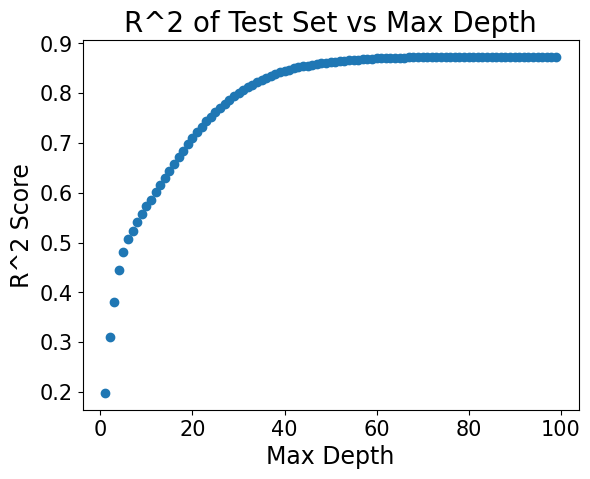

In [21]:
plt.scatter(depths, scores)
plt.xlabel("Max Depth", fontsize = 17)
plt.ylabel("R^2 Score", fontsize = 17)
plt.title("R^2 of Test Set vs Max Depth", fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

ValueError: x and y must be the same size

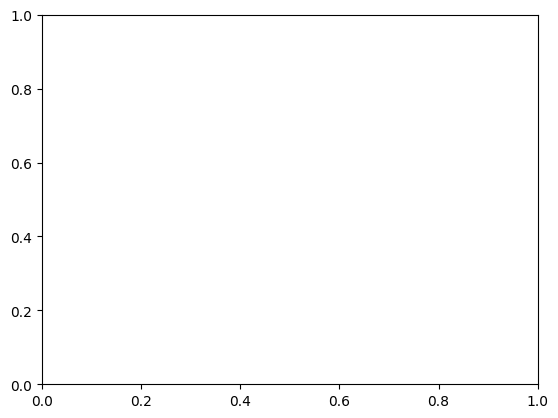

In [214]:
depth = 1
depths = []
scores = []
loss = []
X = data_10[['PowerPerNode', 'index1', 'TempReadings']].to_pandas()
y = data_10['NodeTemp'].to_pandas()
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.35)
while depth < 100:
    depths.append(depth)
    regr = DecisionTreeRegressor(max_depth = depth)
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test, y_test))
    loss.append((y_test - regr.predict(X_test))**2)
    depth += 1
plt.scatter(depths, scores)

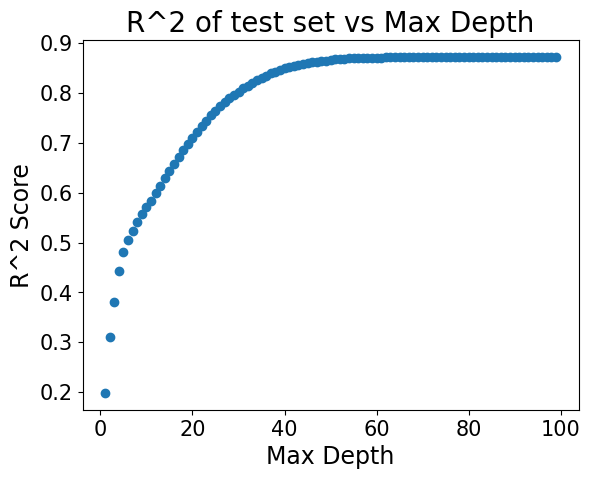

In [223]:
plt.scatter(depths, scores)
plt.xlabel("Max Depth", fontsize = 17)
plt.ylabel("R^2 Score", fontsize = 17)
plt.title("R^2 of test set vs Max Depth", fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.savefig("depths vs scores")

In [206]:
regr_10, X_train, X_test, y_train, y_test = get_regression(data_10)

In [45]:
regr_10_nolayer, X_train, X_test, y_train, y_test = get_regression_nolayer(data_10)

In [21]:
params = regr_10_nolayer.get_params()

In [22]:
params

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 50,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [190]:
print(get_score(regr_10, X_train, X_test, y_train, y_test))

(0.8718937437198653, array([0.87095706, 0.87066513, 0.87342516, 0.87039249, 0.87022756]))


In [139]:
regr_10_new, X_train, X_test, y_train, y_test = get_regression(new_data_10)

In [140]:
print(get_score(regr_10_new, X_train, X_test, y_train, y_test))

(0.8547091080518183, array([0.85596209, 0.85581139, 0.85244271, 0.8555484 , 0.85670325]))


In [155]:
start = time.time()

data_10_new_inputs = impute_data(new_data_10)

end = time.time()

In [156]:
end-start

62.80381941795349

In [159]:
data_10_new_inputs

,TempReadings,index1,PowerPerNode,layer
0,48.39,0.0,0.00219,4.0
1,48.39,1.0,0.00219,4.0
2,48.39,2.0,0.00219,4.0
3,48.39,3.0,0.00219,4.0
4,48.39,4.0,0.00219,4.0
...,...,...,...,...
7199995,47.20,9995.0,0.00190,1.0
7199996,47.20,9996.0,0.00190,1.0
7199997,47.20,9997.0,0.00190,1.0
7199998,47.20,9998.0,0.00190,1.0


In [23]:
layer4_test_power_file = cudf.read_csv("tier0_ptrace(1).csv")
layer4_test_power = layer4_test_power_file['Power'].sum()
layer4_test_power

130.4671653657095

In [24]:
testDf = cudf.DataFrame()
testDf["Powerusage"] = [layer4_test_power, layer1_power]
testDf['Temperature_files'] = ["testoutput.cir.csv", "testoutput.cir.csv"]
testDf['Layer_Number'] = [4,1]

In [25]:
testDf

,Powerusage,Temperature_files,Layer_Number
0,130.467165,testoutput.cir.csv,4
1,19.000000,testoutput.cir.csv,1


In [28]:
data = generate_data(randNodes, testDf)


In [29]:
# data.loc[data["NodeTemp"] == (data["NodeTemp"].max())]

In [30]:
data

,PowerPerNode,NodeTemp,NodeName,index1,layer,TempReadings
0,0.013047,51.05,V(NODE4_0_0),0,4,49.69
1,0.013047,51.05,V(NODE4_0_1),1,4,49.69
2,0.013047,51.04,V(NODE4_0_2),2,4,49.69
3,0.013047,51.04,V(NODE4_0_3),3,4,49.69
4,0.013047,51.03,V(NODE4_0_4),4,4,49.69
...,...,...,...,...,...,...
19995,0.001900,48.48,V(NODE1_99_95),9995,1,50.67
19996,0.001900,48.47,V(NODE1_99_96),9996,1,50.67
19997,0.001900,48.46,V(NODE1_99_97),9997,1,50.67
19998,0.001900,48.45,V(NODE1_99_98),9998,1,50.67


In [608]:
getData(1, testDf)

,PowerPerNode,NodeTemp,NodeName,index1,layer
0,0.0019,52.66,V(NODE1_0_0),0,1
1,0.0019,52.65,V(NODE1_0_1),1,1
2,0.0019,52.65,V(NODE1_0_2),2,1
3,0.0019,52.64,V(NODE1_0_3),3,1
4,0.0019,52.63,V(NODE1_0_4),4,1
...,...,...,...,...,...
9995,0.0019,48.48,V(NODE1_99_95),9995,1
9996,0.0019,48.47,V(NODE1_99_96),9996,1
9997,0.0019,48.46,V(NODE1_99_97),9997,1
9998,0.0019,48.45,V(NODE1_99_98),9998,1


In [139]:
data = getNewData(data, randNodes)

In [487]:
data_inputs = impute_data(data)

In [488]:
data_inputs

,TempReadings,index1,PowerPerNode,layer
0,48.28,0.0,0.003447,4.0
1,48.28,1.0,0.003447,4.0
2,48.28,2.0,0.003447,4.0
3,48.28,3.0,0.003447,4.0
4,48.28,4.0,0.003447,4.0
...,...,...,...,...
19995,48.91,9995.0,0.001900,1.0
19996,48.91,9996.0,0.001900,1.0
19997,48.91,9997.0,0.001900,1.0
19998,48.91,9998.0,0.001900,1.0


In [48]:
X_new = data[['PowerPerNode','index1','TempReadings']].iloc[10000:].to_pandas()
X_new

,PowerPerNode,index1,TempReadings
10000,0.0019,0,50.67
10001,0.0019,1,50.67
10002,0.0019,2,50.67
10003,0.0019,3,50.67
10004,0.0019,4,50.67
...,...,...,...
19995,0.0019,9995,50.67
19996,0.0019,9996,50.67
19997,0.0019,9997,50.67
19998,0.0019,9998,50.67


In [49]:
r2_score(regr_10_nolayer.predict(X_new), data['NodeTemp'].iloc[10000:].to_pandas())

-1.4777323650889778

In [588]:
start = time.time()

prediction = regr_10.predict(X_new)

end = time.time()

Code to generate a visualpact file for the first predicted layer 4 of the minimum regr_10 model
-When Running VisualPACT with model generated file
-need to specificy which layer, and select kelvin = true because the model already applied a kelvin offset. 

In [589]:
end-start

0.0014524459838867188

In [58]:
data_10["NodeName"].iloc[3610000:3620000]

3610000      V(NODE1_0_0)
3610001      V(NODE1_0_1)
3610002      V(NODE1_0_2)
3610003      V(NODE1_0_3)
3610004      V(NODE1_0_4)
                ...      
3619995    V(NODE1_99_95)
3619996    V(NODE1_99_96)
3619997    V(NODE1_99_97)
3619998    V(NODE1_99_98)
3619999    V(NODE1_99_99)
Name: NodeName, Length: 10000, dtype: object

In [35]:
prediction = regr_10_nolayer.predict(X_new)
prediction = prediction.reshape(-1,1)
p = cudf.DataFrame(prediction)
first_layer = p.transpose()
first_layer.columns = data["NodeName"].iloc[:10000].to_pandas().to_list()
first_layer.to_csv("../VisualPACT/model_predictions/10_temp_readings/layer_4/predicted_test2_layer1_nolayer.cir.csv")

In [106]:
prediction = regr_10.predict(data_10[['PowerPerNode', 'index1', 'TempReadings', 'layer']].to_pandas())
prediction = prediction.reshape(-1,1)
p = cudf.DataFrame(prediction)
first_layer = p.iloc[7190000:7200000].transpose()
first_layer.columns = data_10["NodeName"].iloc[3600000:3610000].to_pandas().to_list()
first_layer.to_csv("predicted_output260_layer1.cir.csv") #minimum model prediction for the first layer

In [146]:
print(get_random(50))

[3166, 8994, 2237, 1525, 664, 4317, 7596, 9846, 774, 1739, 231, 8335, 2341, 5442, 6989, 5002, 7934, 1207, 591, 232, 7688, 509, 511, 6620, 9705, 4593, 2241, 6411, 8329, 2071, 4912, 1597, 6879, 2683, 1344, 3564, 4452, 8723, 5805, 6533, 4806, 258, 8153, 4272, 9577, 1123, 9884, 6250, 5745, 2009]


In [271]:
randNodes20 = [1322, 7102, 6675, 1979, 5896, 1051, 2521, 4044, 2379, 5022, 8273, 4658, 8678, 5758, 8701, 3196, 1148, 227, 4655, 810]

In [80]:
data_20 = generate_data(randNodes20, df)
data_20.to_csv("new_data_20.csv")

In [272]:
data_20 = cudf.read_csv("new_data_20.csv")


In [304]:
new_data_20 = getNewData(data_20, randNodes20)

In [305]:
new_data_20.iloc[randNodes20[0]]

,Unnamed: 0,PowerPerNode,NodeTemp,NodeName,index1,layer,TempReadings
1322,1322,0.00219,48.15,V(NODE4_13_22),1322,4,48.15


In [306]:
regr_20_new, X_train, X_test, y_train, y_test = get_regression(new_data_20)

In [30]:
print(get_score(regr_20_new, X_train, X_test, y_train, y_test))

(0.8711092924793151, array([0.87149608, 0.87048506, 0.86964264, 0.87081213, 0.87168396]))


In [273]:
regr_20, X_train, X_test, y_train, y_test = get_regression(data_20)

In [35]:
print(get_score(regr_20, X_train, X_test, y_train, y_test))

(0.8708641627421201, array([0.87153499, 0.87229378, 0.87157605, 0.86931194, 0.87151916]))


In [36]:
new_data_20_inputs = impute_data(new_data_20)

In [314]:
data20 = generate_data(randNodes20, testDf)

In [285]:
data20

,PowerPerNode,NodeTemp,NodeName,index1,layer,TempReadings
0,0.013047,51.05,V(NODE4_0_0),0,4,49.94
1,0.013047,51.05,V(NODE4_0_1),1,4,49.94
2,0.013047,51.04,V(NODE4_0_2),2,4,49.94
3,0.013047,51.04,V(NODE4_0_3),3,4,49.94
4,0.013047,51.03,V(NODE4_0_4),4,4,49.94
...,...,...,...,...,...,...
19995,0.001900,48.48,V(NODE1_99_95),9995,1,50.91
19996,0.001900,48.47,V(NODE1_99_96),9996,1,50.91
19997,0.001900,48.46,V(NODE1_99_97),9997,1,50.91
19998,0.001900,48.45,V(NODE1_99_98),9998,1,50.91


In [315]:
data20.iloc[:10000] = getNewData(data20.iloc[:10000], randNodes20)

In [316]:
data20_inputs = impute_data(data20)

In [317]:
X_new = data20_inputs[['PowerPerNode','index1','TempReadings','layer' ]].iloc[10000:].to_pandas()

In [318]:
X_new

,PowerPerNode,index1,TempReadings,layer
10000,0.0019,0.0,50.91,1.0
10001,0.0019,1.0,50.91,1.0
10002,0.0019,2.0,50.91,1.0
10003,0.0019,3.0,50.91,1.0
10004,0.0019,4.0,50.91,1.0
...,...,...,...,...
19995,0.0019,9995.0,50.91,1.0
19996,0.0019,9996.0,50.91,1.0
19997,0.0019,9997.0,50.91,1.0
19998,0.0019,9998.0,50.91,1.0


In [149]:
r2_score(regr_20_new.predict(X_new), data20['NodeTemp'].iloc[:10000].to_pandas())

NameError: name 'regr_20_new' is not defined

In [53]:
X_new

,PowerPerNode,index1,TempReadings,layer
0,0.002190,0,46.11,4
1,0.002190,1,46.11,4
2,0.002190,2,46.11,4
3,0.002190,3,46.11,4
4,0.002190,4,46.11,4
...,...,...,...,...
3599995,0.003009,9995,46.36,4
3599996,0.003009,9996,46.36,4
3599997,0.003009,9997,46.36,4
3599998,0.003009,9998,46.36,4


In [369]:
randNodes50 = [3166, 8994, 2237, 1525, 664, 4317, 7596, 9846, 774, 1739, 231, 8335, 2341, 5442, 6989, 5002, 7934, 1207, 591, 232, 7688, 509, 511, 6620, 9705, 4593, 2241, 6411, 8329, 2071, 4912, 1597, 6879, 2683, 1344, 3564, 4452, 8723, 5805, 6533, 4806, 258, 8153, 4272, 9577, 1123, 9884, 6250, 5745, 2009]

In [72]:
data_50 = generate_data(randNodes50, df)
data_50.to_csv("new_data_50.csv")

In [56]:
data_50

,PowerPerNode,NodeTemp,NodeName,index1,layer,TempReadings
0,0.00219,47.69,V(NODE4_0_0),0,4,45.85
1,0.00219,47.69,V(NODE4_0_1),1,4,45.85
2,0.00219,47.69,V(NODE4_0_2),2,4,45.85
3,0.00219,47.69,V(NODE4_0_3),3,4,45.85
4,0.00219,47.70,V(NODE4_0_4),4,4,45.85
...,...,...,...,...,...,...
9995,0.00190,46.53,V(NODE4_99_95),9995,1,46.63
9996,0.00190,46.52,V(NODE4_99_96),9996,1,46.63
9997,0.00190,46.52,V(NODE4_99_97),9997,1,46.63
9998,0.00190,46.52,V(NODE4_99_98),9998,1,46.63


In [370]:
# new_data_50 = cudf.read_csv("new_data_50_different_imputers.csv")
data_50 = cudf.read_csv("new_data_50.csv")

In [43]:
data_50 = data_50.drop(['Unnamed: 0'], axis = 1)

In [44]:
data_50

,PowerPerNode,NodeTemp,NodeName,index1,layer,TempReadings
0,0.00219,47.69,V(NODE4_0_0),0,4,45.85
1,0.00219,47.69,V(NODE4_0_1),1,4,45.85
2,0.00219,47.69,V(NODE4_0_2),2,4,45.85
3,0.00219,47.69,V(NODE4_0_3),3,4,45.85
4,0.00219,47.70,V(NODE4_0_4),4,4,45.85
...,...,...,...,...,...,...
7199995,0.00190,46.53,V(NODE4_99_95),9995,1,46.63
7199996,0.00190,46.52,V(NODE4_99_96),9996,1,46.63
7199997,0.00190,46.52,V(NODE4_99_97),9997,1,46.63
7199998,0.00190,46.52,V(NODE4_99_98),9998,1,46.63


In [89]:
new_data_50 = getNewData(data_50, randNodes50)

In [372]:
data50 = generate_data(randNodes50, testDf)

In [374]:
data50

,PowerPerNode,NodeTemp,NodeName,index1,layer,TempReadings
0,0.013047,51.05,V(NODE4_0_0),0,4,48.05
1,0.013047,51.05,V(NODE4_0_1),1,4,48.05
2,0.013047,51.04,V(NODE4_0_2),2,4,48.05
3,0.013047,51.04,V(NODE4_0_3),3,4,48.05
4,0.013047,51.03,V(NODE4_0_4),4,4,48.05
...,...,...,...,...,...,...
19995,0.001900,48.48,V(NODE1_99_95),9995,1,48.82
19996,0.001900,48.47,V(NODE1_99_96),9996,1,48.82
19997,0.001900,48.46,V(NODE1_99_97),9997,1,48.82
19998,0.001900,48.45,V(NODE1_99_98),9998,1,48.82


In [371]:
regr_50, X_train, X_test, y_train, y_test = get_regression(data_50)

In [84]:
data_50

,Unnamed: 0,PowerPerNode,NodeTemp,NodeName,index1,layer,TempReadings
0,0,0.00219,47.69,V(NODE4_0_0),0,4,45.85
1,1,0.00219,47.69,V(NODE4_0_1),1,4,45.85
2,2,0.00219,47.69,V(NODE4_0_2),2,4,45.85
3,3,0.00219,47.69,V(NODE4_0_3),3,4,45.85
4,4,0.00219,47.70,V(NODE4_0_4),4,4,45.85
...,...,...,...,...,...,...,...
7199995,9995,0.00190,46.97,V(NODE1_99_95),9995,1,47.07
7199996,9996,0.00190,46.96,V(NODE1_99_96),9996,1,47.07
7199997,9997,0.00190,46.96,V(NODE1_99_97),9997,1,47.07
7199998,9998,0.00190,46.96,V(NODE1_99_98),9998,1,47.07


In [83]:
print(get_score(regr_50, X_train, X_test, y_train, y_test))

(0.8123850629956836, array([0.81802911, 0.81923856, 0.81832336, 0.82004431, 0.81794895]))


In [91]:
new_regr_50, X_train, X_test, y_train, y_test = get_regression(new_data_50)

In [92]:
print(get_score(new_regr_50, X_train, X_test, y_train, y_test))

(0.796960358112654, array([0.80544002, 0.80546587, 0.80549208, 0.80389354, 0.80477741]))


In [93]:
new_data_50_inputs = impute_data(new_data_50)

In [383]:
data50_new = getNewData(data50, randNodes50)

In [384]:
data50_inputs = impute_data(data50_new)

In [396]:
X_new = data50_inputs[['PowerPerNode','index1','TempReadings','layer' ]].iloc[10000:].to_pandas()

In [397]:
X_new

,PowerPerNode,index1,TempReadings,layer
10000,0.0019,0.0,51.83,1.0
10001,0.0019,1.0,51.83,1.0
10002,0.0019,2.0,51.83,1.0
10003,0.0019,3.0,51.83,1.0
10004,0.0019,4.0,51.83,1.0
...,...,...,...,...
19995,0.0019,9995.0,48.82,1.0
19996,0.0019,9996.0,48.82,1.0
19997,0.0019,9997.0,48.82,1.0
19998,0.0019,9998.0,48.82,1.0


In [398]:
r2_score(regr_50.predict(X_new), data50['NodeTemp'].iloc[10000:].to_pandas())

0.23987695698197897

In [63]:
prediction = regr_50.predict(data_50[['PowerPerNode', 'index1', 'TempReadings', 'layer']].to_pandas())
prediction = prediction.reshape(-1,1)
p = cudf.DataFrame(prediction)
first_layer = p.iloc[7190000:7200000].transpose()
first_layer.columns = data_10["NodeName"].iloc[:10000].to_pandas().to_list()
first_layer.to_csv("50readings_predicted_last_layer1.cir.csv")